In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray
import os
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd

In [2]:
uru = gpd.read_file("ury_adm_2020_shp.zip")

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'ury_adm_2020_shp.zip': 'ury_admbnda_adm0_2020' (default), 'ury_admbnda_adm1_2020', 'ury_admbnda_adm2_2020', 'ury_admbndl_ALL_2020'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
def means_plot(folder, month, year, variable=None, model_name=None, scenario=None):

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (year is None or year in file) and (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            data = os.path.join(file_path)
            ds_masked = xr.open_dataset(data)
        
            # Create a new coordinate 'year_month' by extracting the year and month
            ds_masked['year_month'] = ds_masked.time.dt.strftime('%Y-%m')

            # Group by the new 'year_month' coordinate and aggregate (e.g., sum)
            ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)

            if variable=='pr':
                fig, ax = plt.subplots()
                ds_monthly['pr_mmd'].isel(year_month=month).plot(ax=ax)
                uru.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
                plt.show()
            else:
                fig, ax = plt.subplots()
                ds_monthly[f'{variable}'].isel(year_month=month).plot(ax=ax)
                uru.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
                plt.show()
            
            plt.show()

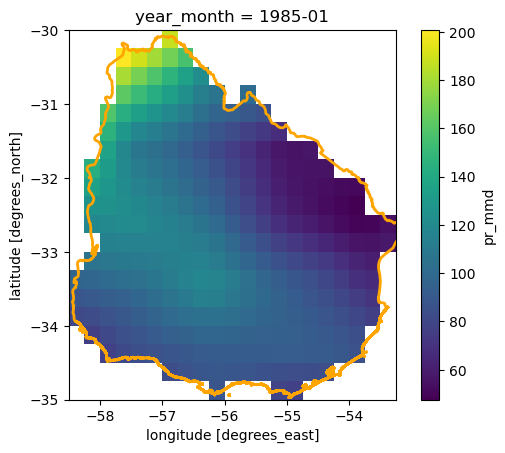

In [4]:
means_plot('filtered_data',month=0,year='1985',variable='pr',model_name='TaiESM1',scenario='historical')

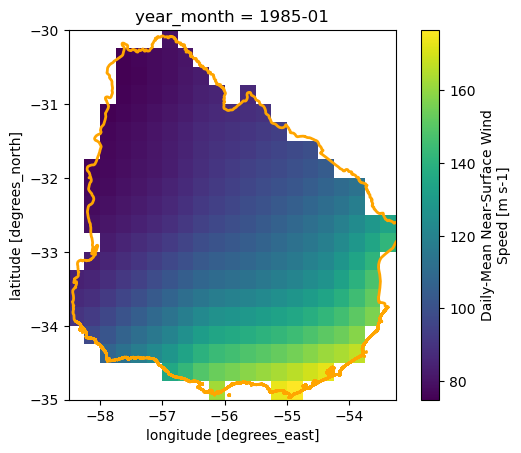

In [5]:
means_plot('filtered_data',month=0,year='1985',variable='sfcWind',model_name='EC-Earth3',scenario='historical')

In [6]:
def monthly_plot(folder, year, variable=None, model_name=None, scenario=None):

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (year is None or year in file) and (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            data = os.path.join(file_path)
            ds_masked = xr.open_dataset(data)
        
            # Create a new coordinate 'year_month' by extracting the year and month
            ds_masked['year_month'] = ds_masked.time.dt.strftime('%Y-%m')

            # Group by the new 'year_month' coordinate and aggregate (e.g., sum)
            ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)

            if variable=='pr':
                # Compute the spatial mean of 'pr_mmd' for each month
                ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'],skipna=True)
                ds_monthly['pr_mmd'].plot.imshow(x="lon", y="lat", col="year_month", col_wrap=4,aspect=1, size=3)
            else:
                ds_monthly_spatial_mean = ds_monthly[f'{variable}'].mean(dim=['lat', 'lon'],skipna=True)
                ds_monthly[f'{variable}'].plot.imshow(x="lon", y="lat", col="year_month", col_wrap=4,aspect=1, size=3)
            
            plt.show()

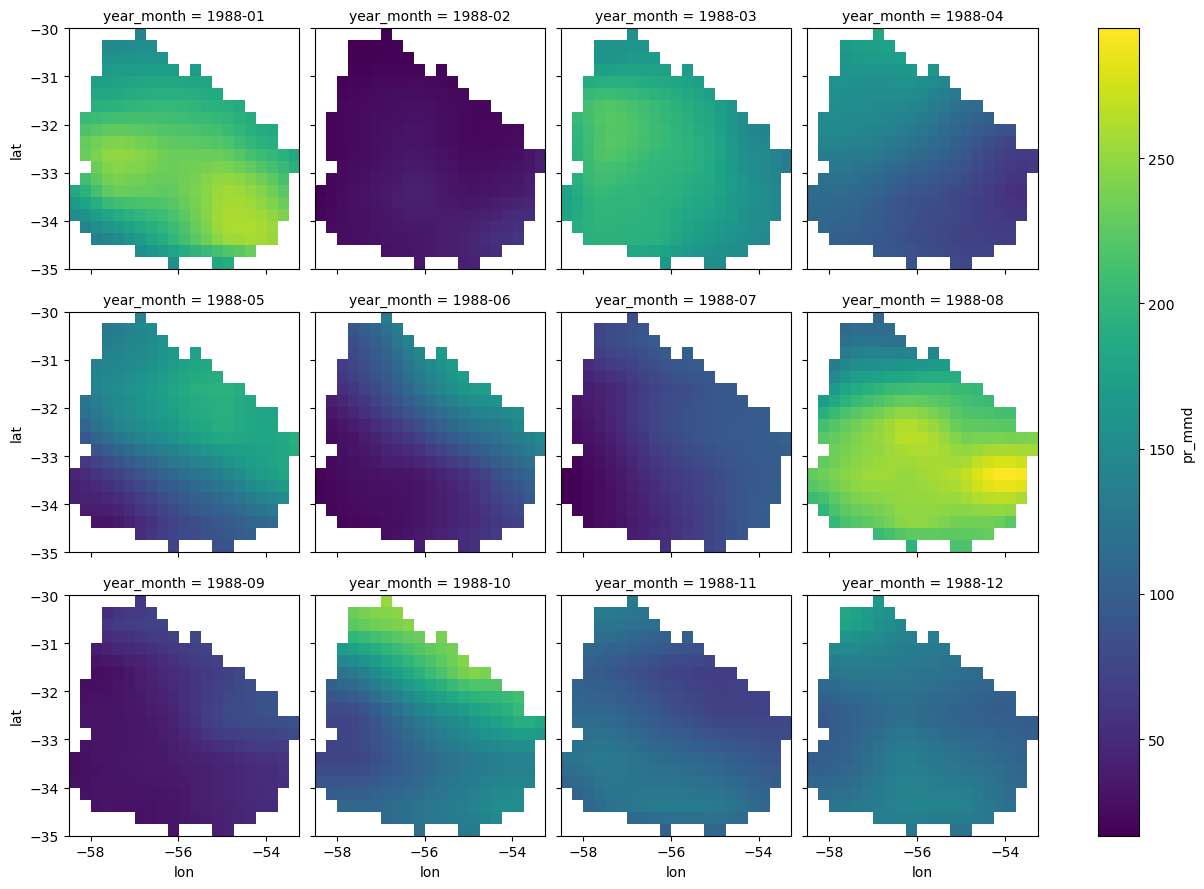

In [7]:
monthly_plot('filtered_data',year='1988',variable='pr',model_name='TaiESM1',scenario='historical')

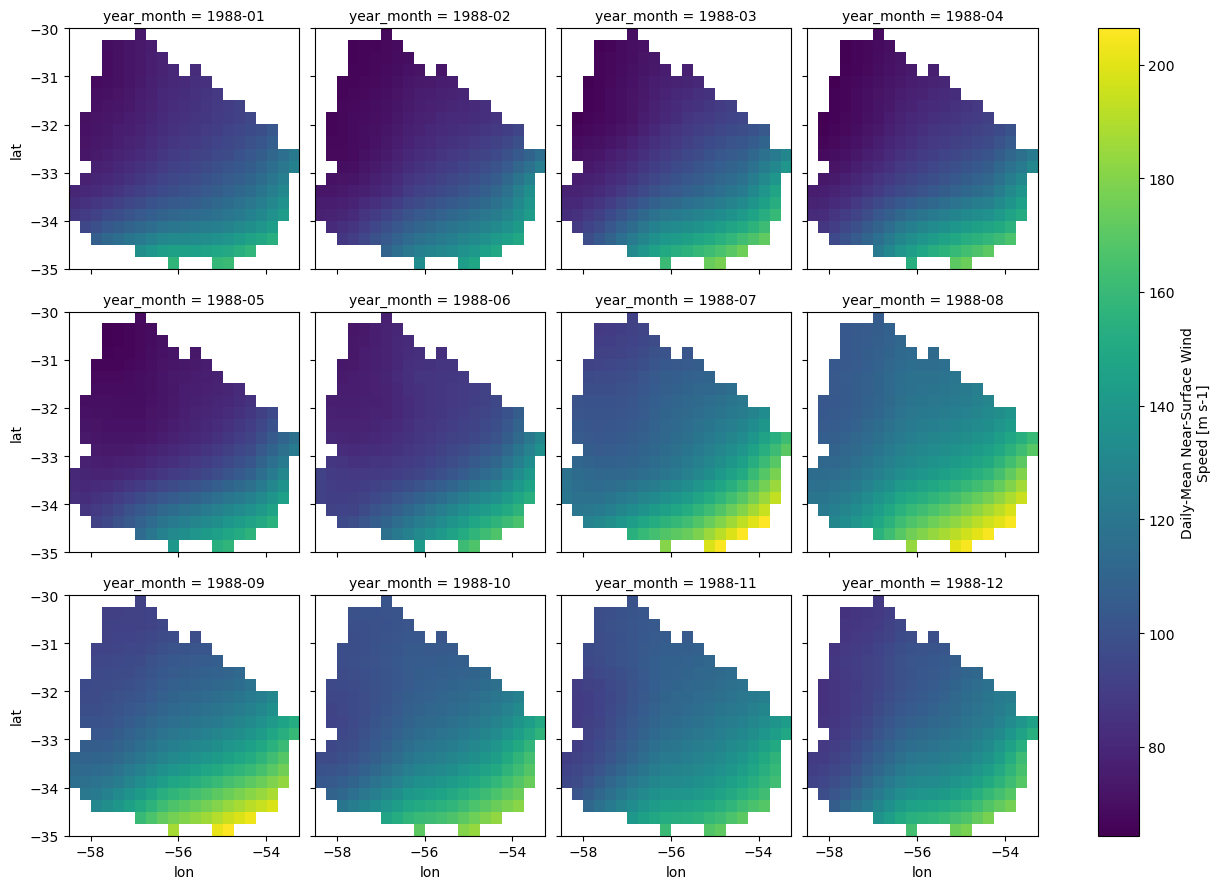

In [8]:
monthly_plot('filtered_data',year='1988',variable='sfcWind',model_name='EC-Earth3',scenario='historical')

In [10]:
def means_dataframe(folder,variable=None, model_name=None, scenario=None):
    dataframes = []

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if (variable is None or variable in file) and (model_name is None or model_name in file) and (scenario is None or scenario in file):
            ds_masked = xr.open_dataset(file_path)
            ds_masked = ds_masked.assign_coords(year_month=ds_masked.time.dt.strftime('%Y-%m'))
            ds_monthly = ds_masked.groupby('year_month').sum(skipna=False)

            if variable=='pr':
                ds_monthly_spatial_mean = ds_monthly['pr_mmd'].mean(dim=['lat', 'lon'], skipna=True)
            else:
                ds_monthly_spatial_mean = ds_monthly['variable'].mean(dim=['lat', 'lon'], skipna=True)
                
            dataframes.append(ds_monthly_spatial_mean.to_dataframe())

    result=pd.concat(dataframes)
    result=result.sort_values('year_month')
    
    return result

In [11]:
EC_Earth3_historical=means_dataframe('filtered_data',variable='pr', model_name='EC-Earth3_', scenario='historical')

In [12]:
EC_Earth3_historical.head()

,pr_mmd
year_month,
1985-01,105.662392
1985-02,195.010895
1985-03,37.098259
1985-04,144.234116
1985-05,110.781372


In [13]:
TaiESM1_historical=means_dataframe('filtered_data',variable='pr', model_name='TaiESM1', scenario='historical')

In [14]:
EC_Earth3_ssp126=means_dataframe('filtered_data',variable='pr', model_name='EC-Earth3_', scenario='ssp126')

In [15]:
TaiESM1_ssp126=means_dataframe('filtered_data',variable='pr', model_name='TaiESM1', scenario='ssp126')

In [16]:
#Split data into future 1 and future 2
EC_Earth3_ssp126_2544=EC_Earth3_ssp126.loc['2025-01':'2044-12']
EC_Earth3_ssp126_4564=EC_Earth3_ssp126.loc['2025-01':'2044-12']
TaiESM1_ssp126_2544=TaiESM1_ssp126.loc['2025-01':'2044-12']
TaiESM1_ssp126_4564=TaiESM1_ssp126.loc['2025-01':'2044-12']

In [17]:
# def clasification(historical_dataframe,dataframe):   
#     quintile_0=historical_dataframe.quantile(0).item()
#     quintile_02=historical_dataframe.quantile(0.2).item()
#     quintile_04=historical_dataframe.quantile(0.4).item()
#     quintile_06=historical_dataframe.quantile(0.6).item()
#     quintile_08=historical_dataframe.quantile(0.8).item()
#     quintile_1=historical_dataframe.quantile(1).item()

#     output = dataframe.copy()
#     year_month=dataframe.index.tolist()
#     for i in year_month:
#         pr=dataframe.loc[i, 'pr_mmd']
#         if pr<quintile_0:
#             output.loc[i, 'pr_cat']=0
#         elif  quintile_0 <= pr < quintile_02:
#             output.loc[i, 'pr_cat']=1
#         elif  quintile_02 <= pr < quintile_04:
#             output.loc[i, 'pr_cat']=2
#         elif  quintile_04 <= pr < quintile_06:
#             output.loc[i, 'pr_cat']=3
#         elif  quintile_06 <= pr < quintile_08:
#             output.loc[i, 'pr_cat']=4
#         elif  quintile_08 <= pr < quintile_1:
#             output.loc[i, 'pr_cat']=5
#         elif  pr > quintile_1:
#             output.loc[i, 'pr_cat']=6
#     return output

In [18]:
def classification(variable,historical_dataframe,dataframe):
    quintile_0=historical_dataframe.quantile(0).item()
    quintile_02=historical_dataframe.quantile(0.2).item()
    quintile_04=historical_dataframe.quantile(0.4).item()
    quintile_06=historical_dataframe.quantile(0.6).item()
    quintile_08=historical_dataframe.quantile(0.8).item()
    quintile_1=historical_dataframe.quantile(1).item()

    output = dataframe.copy()
    year_month=dataframe.index.tolist()
    for i in year_month:
        if variable=='pr':
            var_value=dataframe.loc[i, 'pr_mmd']
        else:
            var_value=dataframe.loc[i, f'{variable}']
            
        if var_value<quintile_0:
            output.loc[i, f'{variable}_cat']=0
        elif  quintile_0 <= var_value < quintile_02:
            output.loc[i, f'{variable}_cat']=1
        elif  quintile_02 <= var_value < quintile_04:
            output.loc[i, f'{variable}_cat']=2
        elif  quintile_04 <= var_value < quintile_06:
            output.loc[i, f'{variable}_cat']=3
        elif  quintile_06 <= var_value < quintile_08:
            output.loc[i, f'{variable}_cat']=4
        elif  quintile_08 <= var_value < quintile_1:
            output.loc[i, f'{variable}_cat']=5
        elif  var_value > quintile_1:
            output.loc[i, f'{variable}_cat']=6
    return output

In [19]:
EC_Earth3_historical_8514=classification('pr',EC_Earth3_historical,EC_Earth3_historical)
TaiESM1_historical_8514=classification('pr',TaiESM1_historical,TaiESM1_historical)

In [20]:
EC_Earth3_ssp126_2544=classification('pr',EC_Earth3_historical,EC_Earth3_ssp126_2544)
EC_Earth3_ssp126_4564=classification('pr',EC_Earth3_historical,EC_Earth3_ssp126_4564)
TaiESM1_ssp126_2544=classification('pr',TaiESM1_historical,EC_Earth3_ssp126_2544)
TaiESM1_ssp126_4564=classification('pr',TaiESM1_historical,TaiESM1_ssp126_4564)

In [21]:
count=0
severetiy=0
episodes_vector=[]
severity_vector=[]

year_month=EC_Earth3_ssp126_4564.index.tolist()

consecutive_months = 0

for i in year_month:
    cat=EC_Earth3_ssp126_4564.loc[i, 'pr_cat']
    if cat <= 2:
        consecutive_months += 1  # Continue streak
    else:
        if consecutive_months >= 3:
            count += 1
            episodes_vector.append(count)
            severity_vector.append(consecutive_months)
        consecutive_months = 0

In [22]:
episodes_vector

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [23]:
severity_vector

[3, 3, 4, 3, 3, 3, 3, 4, 3]

In [24]:
# def count_and_severity(dataframe):
#     count=0
#     severetiy=0
#     episodes_vector=[]
#     severity_vector=[]

#     year_month=dataframe.index.tolist()

#     consecutive_months = 0

#     for i in year_month:
#         cat=dataframe.loc[i, 'pr_cat']
#         if cat <= 2:
#             consecutive_months += 1  # Continue streak
#         else:
#             if consecutive_months >= 3:
#                 count += 1
#                 episodes_vector.append(count)
#                 severity_vector.append(consecutive_months)
#             consecutive_months = 0
#     return episodes_vector, severity_vector

In [25]:
def count_and_severity(variable,dataframe):
    count=0
    severetiy=0
    episodes_vector=[]
    severity_vector=[]

    year_month=dataframe.index.tolist()

    consecutive_months = 0

    for i in year_month:
        cat=dataframe.loc[i, f'{variable}_cat']
        if cat <= 2:
            consecutive_months += 1  # Continue streak
        else:
            if consecutive_months >= 3:
                count += 1
                episodes_vector.append(count)
                severity_vector.append(consecutive_months)
            consecutive_months = 0
    return episodes_vector, severity_vector

In [26]:
episodes_EC_Earth3_historical_8514,severity_EC_Earth3_historical_8514=count_and_severity('pr',EC_Earth3_historical_8514)
episodes_TaiESM1_historical_8514,severity_TaiESM1_historical_8514=count_and_severity('pr',TaiESM1_historical_8514)

In [27]:
episodes_EC_Earth3_ssp126_2544,severity_EC_Earth3_ssp126_2544=count_and_severity('pr',EC_Earth3_ssp126_2544)
episodes_EC_Earth3_ssp126_4564,severity_EC_Earth3_ssp126_4564=count_and_severity('pr',EC_Earth3_ssp126_4564)
episodes_TaiESM1_ssp126_2544,severity_TaiESM1_ssp126_2544=count_and_severity('pr',TaiESM1_ssp126_2544)
episodes_TaiESM1_ssp126_4564,severity_TaiESM1_ssp126_4564=count_and_severity('pr',TaiESM1_ssp126_4564)

In [28]:
episodes_EC_Earth3_ssp126_2544[-1]

9

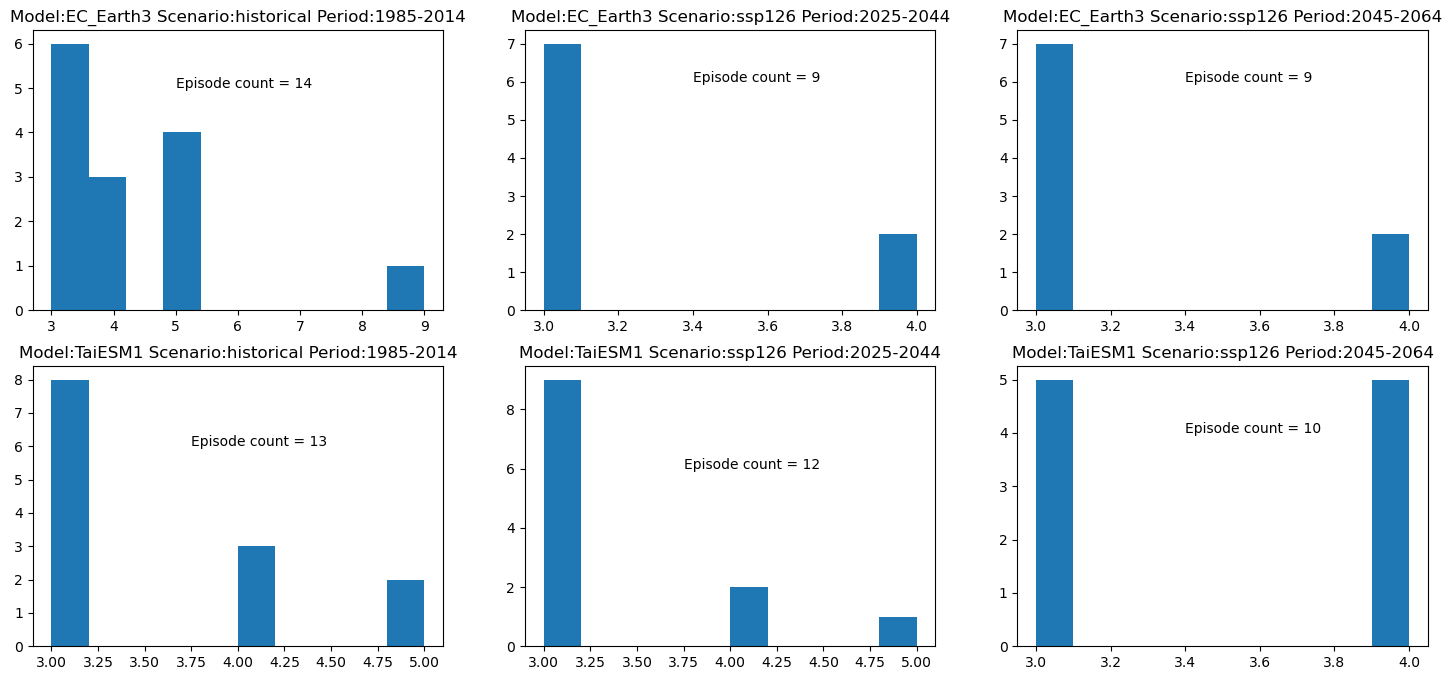

In [29]:
fig, ax = plt.subplots(2,3,figsize=(18,8))

ax[0,0].hist(severity_EC_Earth3_historical_8514)
ax[0,1].hist(severity_EC_Earth3_ssp126_2544)
ax[0,2].hist(severity_EC_Earth3_ssp126_4564)
ax[1,0].hist(severity_TaiESM1_historical_8514)
ax[1,1].hist(severity_TaiESM1_ssp126_2544)
ax[1,2].hist(severity_TaiESM1_ssp126_4564)

ax[0,0].set_title('Model:EC_Earth3 Scenario:historical Period:1985-2014')
ax[0,1].set_title('Model:EC_Earth3 Scenario:ssp126 Period:2025-2044')
ax[0,2].set_title('Model:EC_Earth3 Scenario:ssp126 Period:2045-2064')
ax[1,0].set_title('Model:TaiESM1 Scenario:historical Period:1985-2014')
ax[1,1].set_title('Model:TaiESM1 Scenario:ssp126 Period:2025-2044')
ax[1,2].set_title('Model:TaiESM1 Scenario:ssp126 Period:2045-2064')

ax[0,0].text(5,5,f'Episode count = {episodes_EC_Earth3_historical_8514[-1]}')
ax[0,1].text(3.4,6,f'Episode count = {episodes_EC_Earth3_ssp126_2544[-1]}')
ax[0,2].text(3.4,6,f'Episode count = {episodes_EC_Earth3_ssp126_4564[-1]}')
ax[1,0].text(3.75,6,f'Episode count = {episodes_TaiESM1_historical_8514[-1]}')
ax[1,1].text(3.75,6,f'Episode count = {episodes_TaiESM1_ssp126_2544[-1]}')
ax[1,2].text(3.4,4,f'Episode count = {episodes_TaiESM1_ssp126_4564[-1]}')

plt.show()